In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,GlobalMaxPooling1D, GRU
from tensorflow.keras.models import Sequential

In [2]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [3]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [4]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [5]:
### You can convert the sequences back to the string 
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [6]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

In [7]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)

In [8]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

a) Use GRU with hidden_dimension=64 followed by a one neuron FC layer with a sigmoid
activation.

In [9]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=256))
model.add(GRU(units=64))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           640000    
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 665,025
Trainable params: 665,025
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# Train the model
pred_history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=6, batch_size=32)

Epoch 1/6
1125/1125 [==============================] - 201s 176ms/step - loss: 0.3688 - accuracy: 0.8332 - val_loss: 0.2845 - val_accuracy: 0.8850
Epoch 2/6
1125/1125 [==============================] - 191s 170ms/step - loss: 0.2452 - accuracy: 0.9025 - val_loss: 0.2664 - val_accuracy: 0.8920
Epoch 3/6
1125/1125 [==============================] - 193s 172ms/step - loss: 0.2062 - accuracy: 0.9221 - val_loss: 0.2431 - val_accuracy: 0.8997
Epoch 4/6
1125/1125 [==============================] - 192s 171ms/step - loss: 0.1719 - accuracy: 0.9364 - val_loss: 0.2583 - val_accuracy: 0.9003
Epoch 5/6
1125/1125 [==============================] - 193s 172ms/step - loss: 0.1439 - accuracy: 0.9489 - val_loss: 0.2739 - val_accuracy: 0.8938
Epoch 6/6
1125/1125 [==============================] - 194s 173ms/step - loss: 0.1188 - accuracy: 0.9582 - val_loss: 0.2738 - val_accuracy: 0.8945


In [11]:
test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy[1] * 100.0))

Test Accuracy: 89.19


In [12]:
val_accuracy = model.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy[1] * 100.0))

Val Accuracy: 89.45


In [13]:
#Plot Train vs Validation Accuracy
def TrainVsVal_acc(pred_history):
    plt.figure(figsize=(4, 6))
    plt.plot(np.arange(0, 6), pred_history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, 6), pred_history.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [14]:
#Plot Train vs Validation Loss
def trainVsVal_Loss(pred_history):
    plt.figure(figsize=(4, 6))
    plt.plot(np.arange(0, 6), pred_history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 6), pred_history.history["val_loss"], label="val_loss")
    plt.title("Training Loss vs Validation Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

 Train vs Val Accuracy for GRU


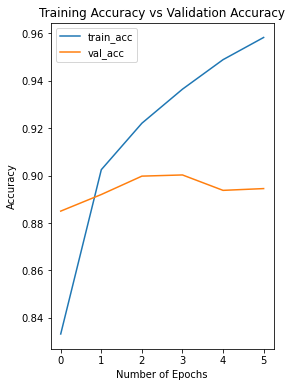

 Train vs Val loss for GRU


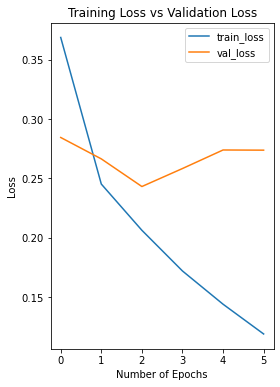

In [15]:
print(" Train vs Val Accuracy for GRU")
TrainVsVal_acc(pred_history)
print(" Train vs Val loss for GRU")
trainVsVal_Loss(pred_history)

b) Use GRU with hidden_dimension=64, followed by Global maxpool 1d, followed by FC with
16 neurons with ReLU, followed by FC layer with single output with sigmoid function.

In [16]:
# Define the model architecture
model_GRU2 = Sequential()
model_GRU2.add(Embedding(input_dim=10000, output_dim=64))
model_GRU2.add(GRU(units=64, return_sequences=True))
model_GRU2.add(GlobalMaxPooling1D())
model_GRU2.add(Dense(units=16, activation='relu'))
model_GRU2.add(Dense(units=1, activation='sigmoid'))



# Compile the model
model_GRU2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model_GRU2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_1 (GRU)                 (None, None, 64)          24960     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 666,017
Trainable params: 666,017
Non-trainable params: 0
________________________________________________

In [17]:
# Train the model
pred_history2=model_GRU2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
  35/1125 [..............................] - ETA: 3:18 - loss: 0.6918 - accuracy: 0.5179

KeyboardInterrupt: 

In [ ]:
test_accuracy = model_GRU2.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.2f' % (test_accuracy[1] * 100.0))

In [ ]:
val_accuracy = model_GRU2.evaluate(x_val, y_val, verbose=0)
print('Val Accuracy: %.2f' % (val_accuracy[1] * 100.0))

In [ ]:
print(" Train vs Val Accuracy for GRU2")
TrainVsVal_acc(pred_history2)
print(" Train vs Val loss for GRU2")
trainVsVal_Loss(pred_history2)